In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import statistics

### This code defines a 'Proc' class to represent a process with arrival and burst times. It includes methods to update the remaining burst time, track the finish time, and create a copy of the process. The 'do' method decreases the remaining burst time, while the '__gt__' method compares processes based on their remaining burst time for priority decisions.

In [2]:
class Proc:
    def __init__(self,arrival,burst):
        self.arrival = arrival
        self.burst = burst
        self.remain_burst = burst
        self.fin_time = None
    
    def __gt__(self,p):
        return self.remain_burst>p.remain_burst
    
    def do(self,t):
        if(self.remain_burst<=0):return
        
        self.remain_burst -=1
        if(self.remain_burst<=0):
            self.fin_time = t+1
            
    def copy(self,arrival=True):
        if(arrival):
            return Proc(self.arrival,self.burst)
        return Proc(0,self.burst)

### This code defines a Cpu class that simulates different CPU scheduling algorithms (FCFS, SJF, SRTF, RR). The class manages processes and their execution order. The run method initiates the chosen scheduling algorithm, and run_srtf, run_fcfs, run_sjf, and run_rr methods execute the respective algorithms. The code tracks the CPU's efficiency, calculated as "waste," representing the total time spent waiting and the handling of various queues for process execution.

In [3]:
class Cpu:
    def __init__(self,procs):
        self.procs = procs
        self.proc_queue = []
        self.ToDo_queue = []
    
    def insert_ToDo(self,p):
        if(len(self.ToDo_queue)==0):
            self.ToDo_queue.append(p)
        else:
            c=0
            #find right place to insert
            while(c!=len(self.ToDo_queue) and self.ToDo_queue[c]<p): c+=1
            self.ToDo_queue = self.ToDo_queue[:c]+[p]+self.ToDo_queue[c:]
    
    def run(self,method,quantom=None):
        if(method=='srtf'):
            self.proc_queue = sorted(copy_procs(procs),key=lambda x: x.arrival)
            return self.run_srtf()
        
        self.proc_queue = copy_procs(procs,False)
        if(method=='fcfs'): return self.run_fcfs()
        if(method=='sjf'): return self.run_sjf()
        if(method=='rr'): return self.run_rr(quantom)
        
        
    def run_srtf(self):
        t=0
        waste=0
        last_proc_arrival = self.proc_queue[-1].arrival
        while(t<=last_proc_arrival or len(self.ToDo_queue)!=0):
            #pop from proc_queue and add to ToDo_queue if arrival time is come
            while(len(self.proc_queue)>0 and t==self.proc_queue[0].arrival):
                self.insert_ToDo(self.proc_queue[0])
                self.proc_queue = self.proc_queue[1:]
            
            #run top of ToDo_queue
            if(len(self.ToDo_queue)==0):break
            self.ToDo_queue[0].do(t)
            if(self.ToDo_queue[0].fin_time!=None):
                proc = self.ToDo_queue[0]
                waste+= proc.fin_time-proc.arrival-proc.burst
                self.ToDo_queue = self.ToDo_queue[1:]
            t+=1
        return waste
            
    def run_fcfs(self):
        t=0
        waste=0
        for proc in self.proc_queue:
            waste+=t
            t+=proc.burst
        return waste
    
    def run_sjf(self):
        self.ToDo_queue = sorted(self.proc_queue,key=lambda x: x.burst)
        t=0
        waste=0
        for proc in self.ToDo_queue:
            waste+=t
            t+=proc.burst
        return waste
    
    def run_rr(self,quantom):
        t=0
        waste=0
        remains = len(self.proc_queue)
        while(remains):
            for proc in self.proc_queue:
                if(proc.remain_burst<=0):continue

                diff = min(quantom,proc.remain_burst)
                proc.remain_burst-=diff
                waste+= (remains-1)*diff
                
                if(proc.remain_burst==0): remains-=1
                    
        return waste
            

## Generate random number

In [6]:
def random_maker(number_of_random ,min_number , max_number):
    random_list = []
    n = len(str((min_number+max_number)//2))
    n = 10 **n
    x = int(time.time()*100000)
    counter = number_of_random
    while(counter > 0):
        y = ((12894038423*x + 1839048)% 3**15)/3**15 * n
        if(y>= min_number and y<= max_number):
            random_list.append(int(y))
            counter = counter -1  
        x = y 
    return random_list

### This code defines a 'runsTest' function to assess the randomness of a given sequence of numbers using the Runs Test statistical method. It calculates the number of runs (alternating increasing and decreasing sequences), expected runs, standard deviation, and a Z-score. If the calculated Z-score exceeds 1.96 (a threshold for a confidence level of approximately 95%), it implies that the numbers are not random; otherwise, they are considered random. The script generates a random sequence of numbers, computes the median, performs the runs test, and outputs whether the sequence is deemed random or not.

In [8]:
def runsTest(l, l_median):
    runs, n1, n2 = 0, 0, 0
    for i in range(len(l)):
        if (l[i] >= l_median and l[i-1] < l_median) or \
                (l[i] < l_median and l[i-1] >= l_median):
            runs += 1

        if(l[i]) >= l_median: n1 += 1
        else: n2 += 1

    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1)))
    z = (runs-runs_exp)/stan_dev
    return z

l = random_maker(10000,1,2000)

l_median= statistics.median(l)

Z = abs(runsTest(l, l_median))

if(Z>1.96):
    print('numbers are not random')
else:
    print('numbers are random')

numbers are random


### The 'create_random_procs' function creates a list of n random processes with arrival times within the specified range and burst times within another specified range. It utilizes a nested 'random_proc' function to generate individual processes and returns a list of these processes.

In [4]:
def create_random_procs(n=10,arrival=(0,20),burst=(1,20)):
    def random_proc():
        arr = random_maker(n ,*arrival)
        bur = random_maker(n ,*burst) 
        return Proc(arr,bur)
    
    return [random_proc() for _ in range(n)]

### The 'copy_procs' function takes a list of processes as input and returns a new list containing copies of these processes. The optional parameter arrival allows the user to choose whether to maintain the original arrival times or set them to zero in the copied processes.

In [1]:
def copy_procs(procs,arrival=True):
    return [proc.copy(arrival) for proc in procs]

In [5]:
procs = create_random_procs()
cpu = Cpu(procs)

## Initially, we generate process instances randomly and input them into four implemented algorithms, then plotting the result

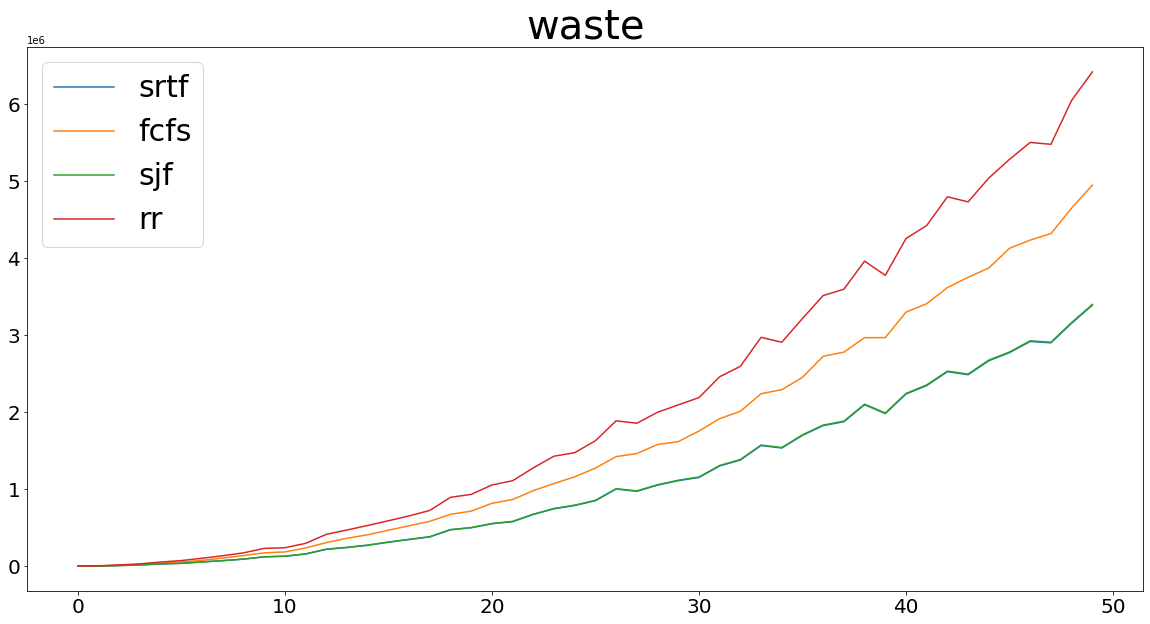

In [6]:
srtf = []
fcfs = []
sjf = []
rr = []
for i in range(5,1000,20):
    procs = create_random_procs(i,arrival=(0,20),burst=(1,20))
    cpu = Cpu(procs)
    srtf.append(cpu.run('srtf'))
    fcfs.append(cpu.run('fcfs'))
    sjf.append(cpu.run('sjf'))
    rr.append(cpu.run('rr',5))
a = pd.DataFrame({'srtf':srtf,'fcfs':fcfs,'sjf':sjf,'rr':rr})
a.plot(figsize=(20,10),fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.title('waste',size=40)
pass

## We create processes with relatively large ranges of starting times

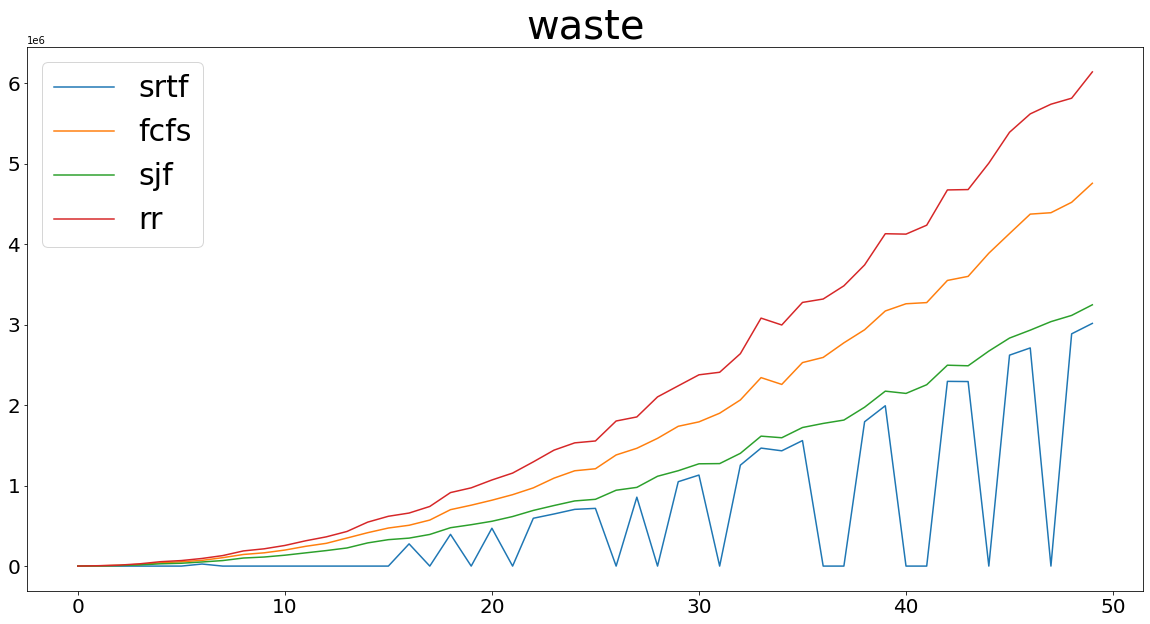

In [7]:
#long arrival range
srtf = []
fcfs = []
sjf = []
rr = []
for i in range(5,1000,20):
    procs = create_random_procs(i,arrival=(0,500),burst=(1,20))
    cpu = Cpu(procs)
    srtf.append(cpu.run('srtf'))
    fcfs.append(cpu.run('fcfs'))
    sjf.append(cpu.run('sjf'))
    rr.append(cpu.run('rr',5))
a = pd.DataFrame({'srtf':srtf,'fcfs':fcfs,'sjf':sjf,'rr':rr})
a.plot(figsize=(20,10),fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.title('waste',size=40)
pass

## We generate processes with relatively large ranges of execution times.

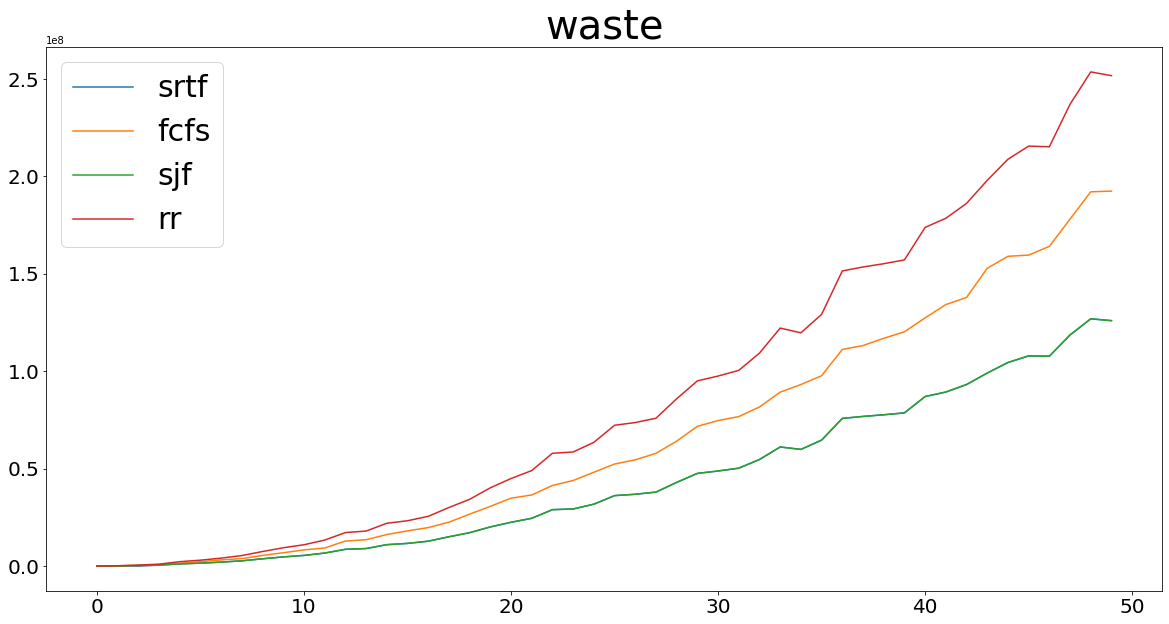

In [8]:
#long range burst time
srtf = []
fcfs = []
sjf = []
rr = []
for i in range(5,1000,20):
    procs = create_random_procs(i,arrival=(0,30),burst=(1,800))
    cpu = Cpu(procs)
    srtf.append(cpu.run('srtf'))
    fcfs.append(cpu.run('fcfs'))
    sjf.append(cpu.run('sjf'))
    rr.append(cpu.run('rr',5))
a = pd.DataFrame({'srtf':srtf,'fcfs':fcfs,'sjf':sjf,'rr':rr})
a.plot(figsize=(20,10),fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.title('waste',size=40)
pass

## We create processes with relatively constrained execution intervals, but with large values.

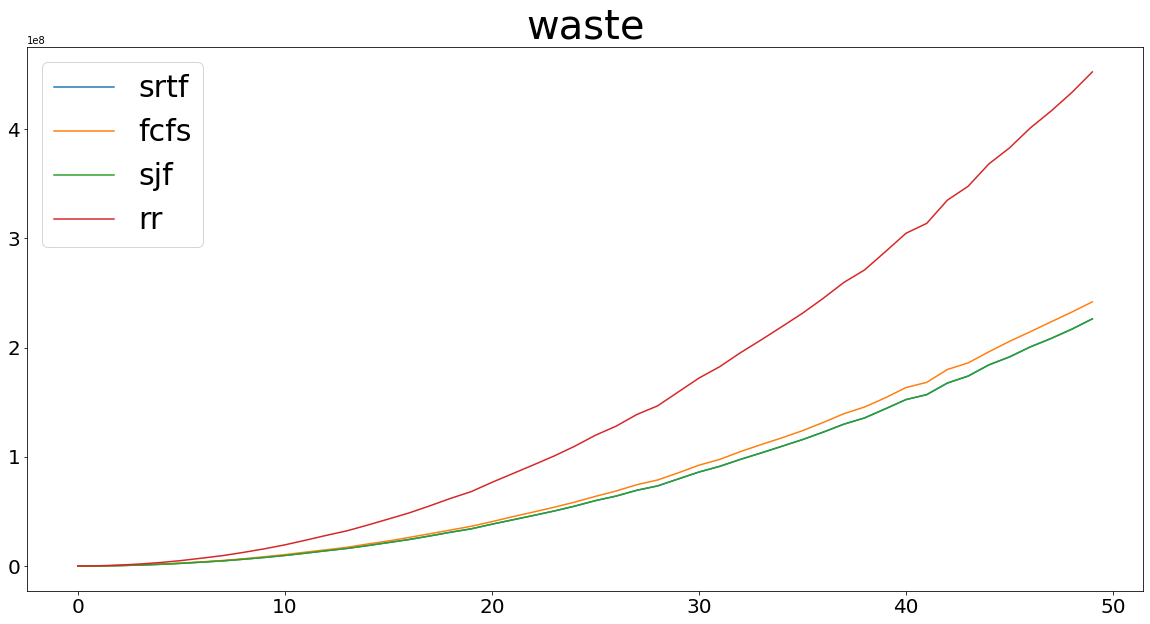

In [9]:
#short range burst time but more burst
srtf = []
fcfs = []
sjf = []
rr = []
for i in range(5,1000,20):
    procs = create_random_procs(i,arrival=(0,30),burst=(400,600))
    cpu = Cpu(procs)
    srtf.append(cpu.run('srtf'))
    fcfs.append(cpu.run('fcfs'))
    sjf.append(cpu.run('sjf'))
    rr.append(cpu.run('rr',5))
a = pd.DataFrame({'srtf':srtf,'fcfs':fcfs,'sjf':sjf,'rr':rr})
a.plot(figsize=(20,10),fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.title('waste',size=40)
pass

## Processes with various quantum values for the Round Robin Algorithm

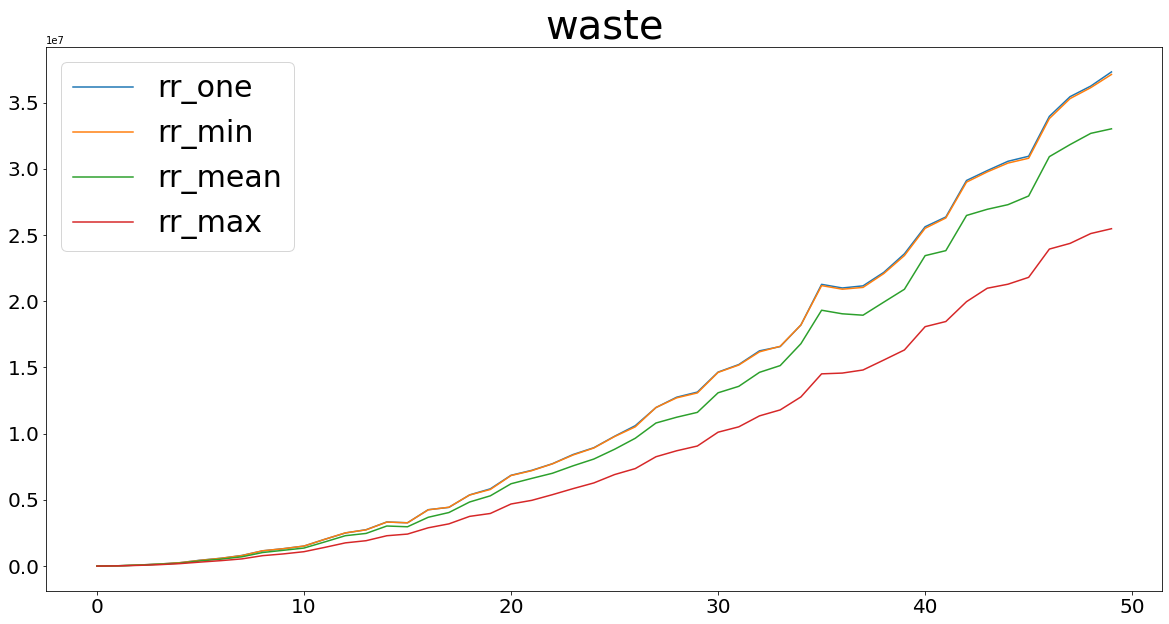

In [10]:
#all kind of rr waste time(rr_max is actually fcfs)
rr_one = []
rr_min = []
rr_mean = []
rr_max = []
for i in range(5,1000,20):
    procs = create_random_procs(i,arrival=(0,30),burst=(10,100))
    cpu = Cpu(procs)
    rr_one.append(cpu.run('rr',1))
    rr_min.append(cpu.run('rr',10))
    rr_mean.append(cpu.run('rr',50))
    rr_max.append(cpu.run('rr',100))
a = pd.DataFrame({'rr_one':rr_one,'rr_min':rr_min,'rr_mean':rr_mean,'rr_max':rr_max})
a.plot(figsize=(20,10),fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.title('waste',size=40)
pass

# Explanation and Interpretation of Results:

The SRTF and SJF algorithms behave nearly identically. The reason behind this lies in their inherent similarity; both algorithms prioritize tasks by sorting them and beginning with the smallest task, which minimizes time waste. However, when the arrival times are substantial, SRTF tends to perform better, as evidenced in the second graph. This occurs because when the range of arrivals is small, SJF, since it has all operations at once, causes significant waste from idle processes while performing a single operation.

On the other hand, among the RR algorithms, increasing the quantum value is more favorable. In the maximum scenario, we approach the FCFS algorithm, which is expected to outperform RR and represents a specific case of RR.